In [27]:
from subprocess import call
import copy
import numpy as np
import matplotlib.pyplot as plt
import csv
%matplotlib notebook

In [14]:
PTS_FILE = "pts_file.csv"
PERF_FILE = "perf_file.csv"
PROGRAM_PATH = "./main"

In [3]:
# Lattice generation
def generate_lattice(xnum, ynum):
    x = np.linspace(0, xnum - 1, num=xnum)
    y = np.linspace(0, ynum - 1, num=ynum)
    xv, yv = np.meshgrid(x, y)
    lattice_list = list(zip(xv.flatten(), yv.flatten()))
    return lattice_list

In [4]:
# Random point generation in square region
def generate_rand_pts_sq(x, y, r, num):
    ret_list = []
    for i in range(num):
        ret_list.append((2 * r * np.random.random_sample() + x - r,
                     2 * r * np.random.random_sample() + y - r))
    return ret_list

In [5]:
# Random point generation in disk region (discard method)
def generate_rand_pts_disk(x, y, r, num):
    ret_list = []
    i = 0
    while i < num:
        pnt = (
            (2 * r * np.random.random_sample() + x - r),
            (2 * r * np.random.random_sample() + y - r)
        )
        if (pnt[0] - x)**2 + (pnt[1] - y)**2 <= r**2:
            ret_list.append(pnt)
            i += 1
    return ret_list

In [6]:
def write_pts_list(pts_list):
    with open(PTS_FILE, "w") as pts_file:
        for pnt in pts_list:
            pts_file.write(str(pnt[0]) + "," + str(pnt[1]) + "\n")

In [7]:
def read_pts_list():
    pts_list = []
    with open(PTS_FILE) as pts_file:
        csv_reader = csv.reader(pts_file, delimiter=",")
        for row in csv_reader:
            pts_list.append(tuple(map(float, row)))
        return pts_list

In [8]:
def move_pnt(pnt, delta_x, delta_y):
    new_pnt = (pnt[0] + delta_x, pnt[1] + delta_y)
    return new_pnt

In [9]:
def replace_pnt(pts_list, pnt, new_pnt): # returns new list with pnt replaced with new_pnt
    assert pnt in pts_list
    ret_list = copy.deepcopy(pts_list)
    ret_list.remove(pnt)
    ret_list.append(new_pnt)
    return ret_list

In [10]:
def plot_pts_list(pts_list):
    plt.scatter(np.array(pts_list)[:,0], np.array(pts_list)[:,1], s=4, c=[[0,0,0]])
    plt.grid(True)
    plt.xlabel("x coordinate")
    plt.ylabel("y coordinate")
    plt.axes().set_aspect('equal')
    plt.show()

In [11]:
def run_average(num_iter):
    perf_dict = dict()
    for i in range(num_iter):
        call(PROGRAM_PATH)
        with open(PERF_FILE) as perf_file:
            csv_reader = csv.reader(perf_file, delimiter=",")
            for row in csv_reader:
                if (row[0] in perf_dict):
                    perf_dict[row[0]] += float(row[1])
                else:
                    perf_dict[row[0]] = float(row[1])
    for i in perf_dict.keys():
        perf_dict[i] /= num_iter
    return perf_dict

In [12]:
def gen_run_average(num_iter, samp_func, x, y, r, n):
    perf_dict = dict()
    for i in range(num_iter):
        write_pts_list(samp_func(x, y, r, n))
        call(PROGRAM_PATH)
        with open(PERF_FILE) as perf_file:
            csv_reader = csv.reader(perf_file, delimiter=",")
            for row in csv_reader:
                if (row[0] in perf_dict):
                    perf_dict[row[0]] += float(row[1])
                else:
                    perf_dict[row[0]] = float(row[1])
    for i in perf_dict.keys():
        perf_dict[i] /= num_iter
    return perf_dict

In [15]:
build_res = [gen_run_average(10, generate_rand_pts_sq, *(0, 0, 1000, 100*i+1))['build'] / 1000000 for i in range(10)]

In [42]:
find_res = [gen_run_average(10, generate_rand_pts_sq, *(0, 0, 1000, 100*i+1))['find'] / 1000 for i in range(10)]

In [32]:
build_res

[0.0027007,
 2.653118,
 6.700274,
 11.35139,
 16.65245,
 21.66806,
 28.10222,
 34.54176,
 40.7567,
 47.78491]

In [18]:
find_res

[299.8, 2852.6, 3376.6, 4179.3, 4404.3, 4729.5, 5027.6, 5057.9, 5936.0, 5996.4]

In [21]:
build_x_list = [100*i+1 for i in range(10)]
build_x_log_list = np.array(build_x_list) * (np.log(build_x_list))**3

In [33]:
find_x_list = [100*i+1 for i in range(10)]
find_x_log_list = (np.log(build_x_list))**3

In [22]:
build_x_list

[1, 101, 201, 301, 401, 501, 601, 701, 801, 901]

In [23]:
build_x_log_list

array([     0.        ,   9928.19990501,  29980.29133924,  55951.95761332,
        86354.74460525, 120364.32281968, 157444.80145809, 197215.33201491,
       239389.19023937, 283741.56852689])

In [43]:
np.polyfit(build_x_log_list, build_res, 1)

array([1.65986894e-04, 1.42875647e+00])

<IPython.core.display.Javascript object>


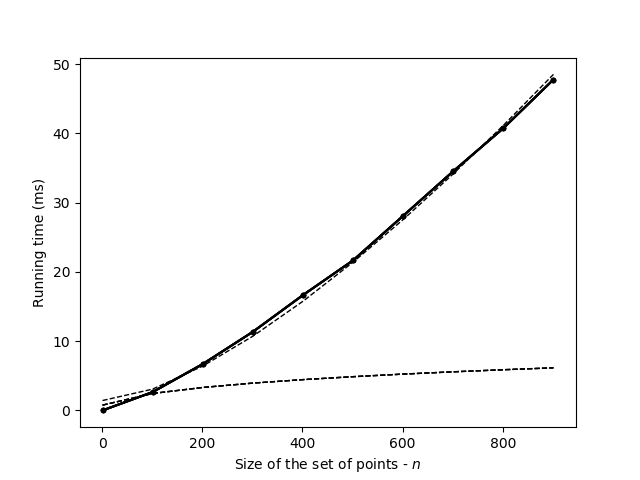

In [31]:
plt.plot(build_x_list, build_res, c=(0,0,0), marker=".")
x = np.linspace(0, 1000, 10)
x = build_x_list
y = 1.65986894e-04 * (x * np.log(x)**3) + 1.42875647e+00
plt.plot(x, y, '--', c=(0,0,0), linewidth=1)
plt.xlabel("Size of the set of points - $n$")
plt.ylabel("Running time (ms)")
plt.savefig("../docs/report/images/range_tree_construction_performance.png")

In [48]:
find_res

[0.1456, 2.9696, 3.5225, 4.2634, 4.3304, 4.6818, 4.7799, 5.0949, 5.743, 5.8102]

In [44]:
np.polyfit(find_x_log_list, find_res, 1)

array([0.01632865, 0.79324621])

<IPython.core.display.Javascript object>


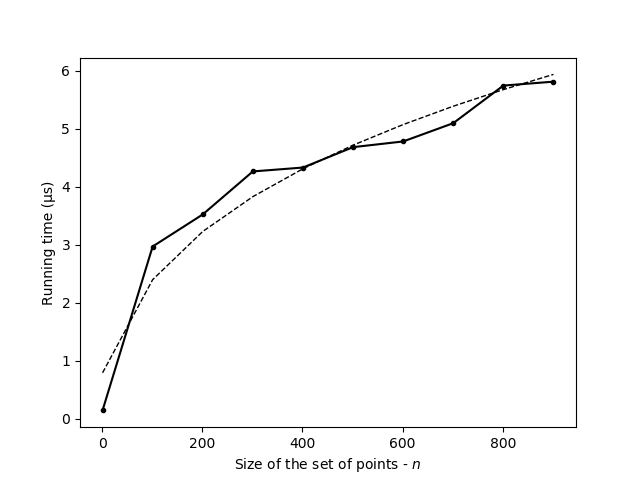

In [46]:
plt.plot(find_x_list, find_res, c=(0,0,0), marker=".")
x = np.linspace(0, 1000, 10)
x = find_x_list
y = 0.01632865 * (np.log(x)**3) + 0.79324621
plt.plot(x, y, '--', c=(0,0,0), linewidth=1)
plt.xlabel("Size of the set of points - $n$")
plt.ylabel("Running time (μs)")
plt.savefig("../docs/report/images/range_tree_search_performance.png")

In [15]:
def gradient(pts_list, pnt, num_iter, dist, eta, category):
    # sample x direction
    pnt_xl = move_pnt(pnt, -dist, 0)
    list_xl = replace_pnt(pts_list, pnt, pnt_xl)
    # plot_pts_list(list_xl)
    write_pts_list(list_xl)
    t_xl = run_average(num_iter)[category]
    pnt_xr = move_pnt(pnt, dist, 0)
    list_xr = replace_pnt(pts_list, pnt, pnt_xr)
    # plot_pts_list(list_xr)
    write_pts_list(list_xr)
    t_xr = run_average(num_iter)[category]
    vec_x = t_xr - t_xl
    # sample y direction
    pnt_yu = move_pnt(pnt, 0, dist)
    list_yu = replace_pnt(pts_list, pnt, pnt_yu)
    # plot_pts_list(list_yu)
    write_pts_list(list_yu)
    t_yu = run_average(num_iter)[category]
    pnt_yd = move_pnt(pnt, 0, -dist)
    list_yd = replace_pnt(pts_list, pnt, pnt_yd)
    # plot_pts_list(list_yd)
    write_pts_list(list_yd)
    t_yd = run_average(num_iter)[category]
    vec_x = (t_xr - t_xl) / dist
    vec_y = (t_yu - t_yd) / dist
    write_pts_list(pts_list)
    return (vec_x*eta, vec_y*eta)

In [16]:
def optimize(pts_list, total_iter, num_iter_train, num_iter_test, dist, eta, category):
    write_pts_list(pts_list)
    old_pts_list = copy.deepcopy(pts_list)
    t_base = run_average(num_iter_test)[category]
    for i in range(total_iter):
        rand_pnt = pts_list[np.random.randint(0, len(pts_list))]
        grad = gradient(pts_list, rand_pnt, num_iter_train, dist, eta, category)
        new_pnt = (rand_pnt[0] + grad[0], rand_pnt[1] + grad[1])
        pts_list = replace_pnt(pts_list, rand_pnt, new_pnt)
        print("Progress {:2.1%}".format(i / total_iter), end="\r")
    plot_pts_list(pts_list)
    write_pts_list(pts_list)
    t_opt = run_average(num_iter_test)[category]
    print("Original time: " + str(t_base) + ", " + "New time: " + str(t_opt))
    write_pts_list(old_pts_list)
    return pts_list

<IPython.core.display.Javascript object>


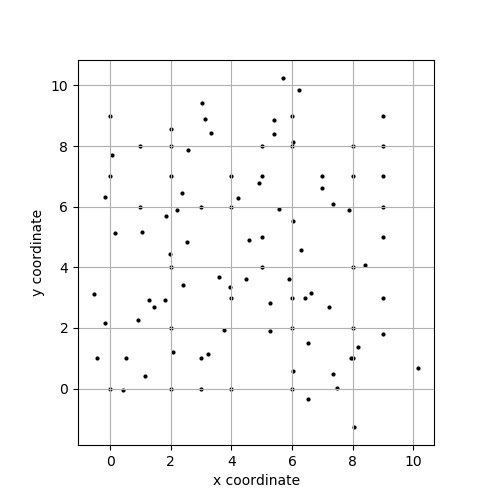

/home/allen/Programs/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Original time: 0.0697400000000001, New time: 0.070888


In [17]:
pts_list = generate_lattice(10, 10)
optimize(pts_list, 100, 5, 500, 0.5, 50, "outer_triangle_partition");